In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def load_df(fp):
	df= pd.read_csv(fp, names=['id', 'ip', 'label', 'text']).set_index('id')
	df.info()
	return df


In [ ]:
# import data
df_train= load_df('/content/twitter_training.csv')
df_valid= load_df('/content/twitter_validation.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 74682 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      74682 non-null  object
 1   label   74682 non-null  object
 2   text    73996 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 3364 to 6960
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      1000 non-null   object
 1   label   1000 non-null   object
 2   text    1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB


In [ ]:
# Kiểm tra giá trị null(NaN)
print(np.sum(df_train.isnull().any(axis=1)))
print(np.sum(df_valid.isnull().any(axis=1)))

686
0


In [ ]:
# Loại bỏ những dòng có giá trị bị thiếu (NaN)
df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73996 entries, 2401 to 9200
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ip      73996 non-null  object
 1   label   73996 non-null  object
 2   text    73996 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


In [ ]:
df_train.head()

,ip,label,text
id,,,
2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2401,Borderlands,Positive,im coming on borderlands and i will murder you...
2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
df_valid.head()

,ip,label,text
id,,,
3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4433,Google,Neutral,Now the President is slapping Americans in the...


In [ ]:
# Đếm số lượng từng giá trị
print("Value counts:\n", df_train['label'].value_counts())
print("Value counts:\n", df_valid['label'].value_counts())

Value counts:
 label
Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64
Value counts:
 label
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

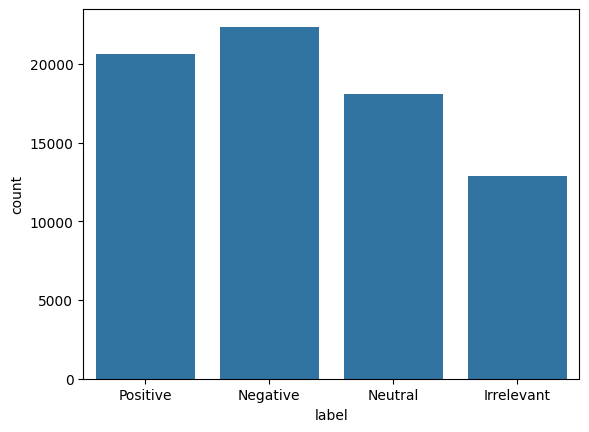

In [ ]:
# Tổng quan về dũ liệu train
sns.countplot(data= df_train, x = 'label' , order=['Positive', 'Negative', 'Neutral' , 'Irrelevant'])


<Axes: xlabel='label', ylabel='count'>

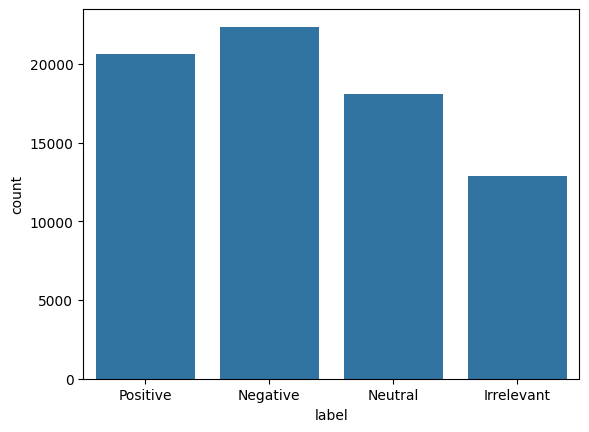

In [ ]:
# Tổng quan về dũ liệu test
sns.countplot(data= df_train, x = 'label' , order=['Positive', 'Negative', 'Neutral' , 'Irrelevant'])

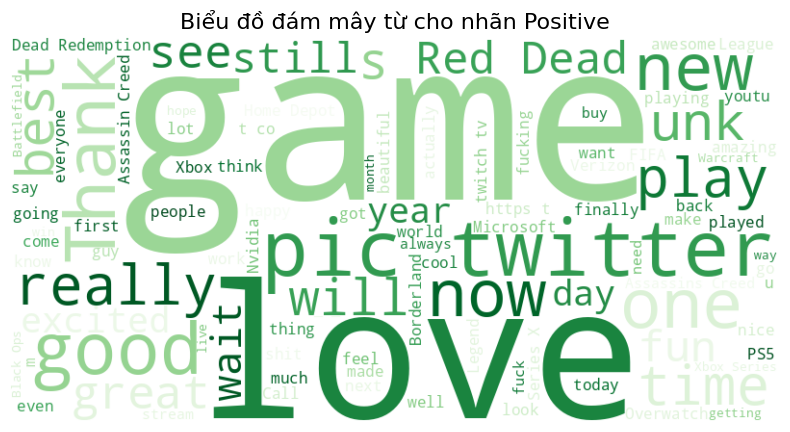

In [ ]:
from wordcloud import WordCloud
# Lọc các dòng dữ liệu có nhãn 'Positive'
positive_text = " ".join(df_train[df_train['label'] == 'Positive']['text'])

# Tạo biểu đồ đám mây từ
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    max_words=100
).generate(positive_text)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Biểu đồ đám mây từ cho nhãn Positive', fontsize=16)
plt.show()


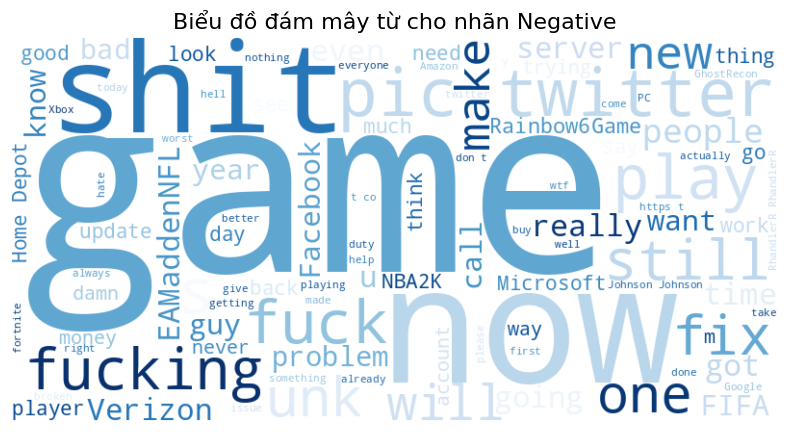

In [ ]:
from wordcloud import WordCloud
# Lọc các dòng dữ liệu có nhãn 'Negative'
positive_text = " ".join(df_train[df_train['label'] == 'Negative']['text'])

# Tạo biểu đồ đám mây từ
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues',
    max_words=100
).generate(positive_text)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Biểu đồ đám mây từ cho nhãn Negative', fontsize=16)
plt.show()

In [ ]:
# Tạo một ánh xạ từ nhãn văn bản sang số
label_mapping = {'Positive': 0, 'Negative': 1, 'Neutral': 2, 'Irrelevant': 2} # Neutral và Irrelevant được gộp lại

# Chuyển nhãn thành số cho tập huấn luyện
y_train = [label_mapping[label] for label in df_train['label']]

# Chuyển nhãn thành số cho tập kiểm thử
y_test = [label_mapping[label] for label in df_valid['label']]


In [ ]:
#Tạo một đường dẫn để vector hóa và chuẩn hóa dữ liệu văn bản
text_pipeline = make_pipeline(
    CountVectorizer(stop_words='english'),
    TfidfTransformer()
)
# Chuyển đổi dữ liệu huấn luyện và kiểm tra
X_train_transformed = text_pipeline.fit_transform(df_train['text'])
X_test_transformed = text_pipeline.transform(df_valid['text'])

#
print(f"Shape of the transformed training data: {X_train_transformed.shape}")
print(f"Shape of the transformed test data: {X_test_transformed.shape}")


Shape of the transformed training data: (73996, 30764)
Shape of the transformed test data: (1000, 30764)


In [ ]:
# Huấn luyện mô hình Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_transformed, y_train)

# Dự đoán mô hình
y_pred = nb_model.predict(X_test_transformed)

# Accuracy
accuracy_nb = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_nb:.4f}")

# Classification report + confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.8740
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       277
           1       0.83      0.89      0.86       266
           2       0.89      0.89      0.89       457

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



In [ ]:
# Huấn luyện mô hình Logistic Regression
lg_model =LogisticRegression(max_iter=10000)
lg_model.fit(X_train_transformed, y_train)

# Dự đoán mô hình
y_pred = lg_model.predict(X_test_transformed)

# Accuracy
accuracy_lg = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_lg:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9280
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       277
           1       0.91      0.95      0.93       266
           2       0.95      0.93      0.94       457

    accuracy                           0.93      1000
   macro avg       0.92      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
# Huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn.fit(X_train_transformed, y_train)
# Dự đoán mô hình
y_pred = knn.predict(X_test_transformed)

# Accuracy
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_knn:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9770
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       277
           1       0.96      0.97      0.97       266
           2       0.99      0.98      0.98       457

    accuracy                           0.98      1000
   macro avg       0.97      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [ ]:
# Huấn luyện mô hình Decision Tree
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, random_state=42)
clf.fit(X_train_transformed, y_train)

# Dự đoán mô hình
y_pred = clf.predict(X_test_transformed)
# Accuracy
accuracy_clf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_clf:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9230
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       277
           1       0.90      0.95      0.93       266
           2       0.94      0.92      0.93       457

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



Code chạy lâu


In [ ]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_transformed, y_train)

# Dự đoán mô hình
y_pred = rf_model.predict(X_test_transformed)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_rf:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9560
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       277
           1       0.97      0.94      0.96       266
           2       0.94      0.98      0.96       457

    accuracy                           0.96      1000
   macro avg       0.96      0.95      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [ ]:
# Huấn luyện mô hình SVM
# Nhân linear
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
# Accuracy
accuracy_svm_linear = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_svm_linear:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9390
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       277
           1       0.93      0.95      0.94       266
           2       0.95      0.94      0.95       457

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [ ]:
# Huấn luyện mô hình SVM
# Nhân kernal
model = SVC(kernel='rbf',random_state=42)
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)
# Accuracy
accuracy_svm_rbf = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_svm_rbf:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9760
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       277
           1       0.98      0.97      0.98       266
           2       0.97      0.98      0.98       457

    accuracy                           0.98      1000
   macro avg       0.98      0.97      0.98      1000
weighted avg       0.98      0.98      0.98      1000



                 Model  Accuracy
0          Naive Bayes     0.874
1  Logistic Regression     0.928
2                  KNN     0.977
3        Decision Tree     0.923
4        Random Forest     0.956
5           SVM_linear     0.939
6              SVM_rbf     0.976


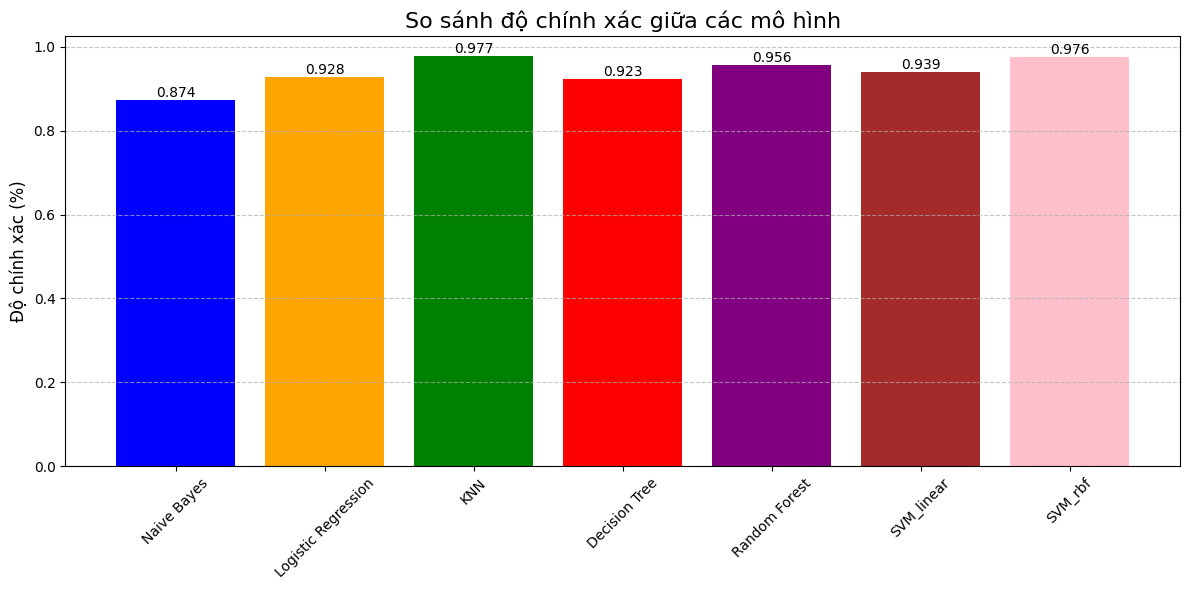

In [ ]:
#Tạo biểu đồ
models = ['Naive Bayes', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'SVM_linear', 'SVM_rbf']
accuracy = [accuracy_nb, accuracy_lg, accuracy_knn, accuracy_clf, accuracy_rf, accuracy_svm_linear, accuracy_svm_rbf]

data = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
})

print(data)
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
plt.figure(figsize=(12, 6))
bars = plt.bar(data['Model'], data['Accuracy'], color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )
plt.title('So sánh độ chính xác giữa các mô hình', fontsize=16)
plt.ylabel('Độ chính xác (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
